In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA , KernelPCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from lime import lime_tabular
import shap
import pickle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import warnings

In [74]:
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings("ignore", message="This figure includes Axes that are not compatible with tight_layout", module="matplotlib")


In [96]:
!pip install lime

     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/275.7 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283842 sha256=ac3410c0b0f13490755188d01abd10a02df3d0f16f34248d8b3bb961d61563d9
  Stored in directory: c:\users\manas\appdata\local\pip\cache\wheels\e7\5d\0e\4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [7]:
def load_data():
    # Loading the metadata and label files
    metadata_A = pd.read_excel("Data/METADATA_A.xlsx")
    metadata_B = pd.read_excel("Data/METADATA_B.xlsx")
    labels = pd.read_excel("Data/LABELS.xlsx")  
    
    # Merging both metadata based on participant_id
    metadata = metadata_A.merge(metadata_B, on="participant_id", how="inner")
    metadata = metadata.merge(labels, on="participant_id", how="inner")
    
    
    connectome = pd.read_csv("Data/FUNCTIONAL_CONNECTOME_MATRICES.csv", index_col=0)
    
   
    
    return metadata, connectome

In [9]:
metadata, connectome = load_data()
print(f"Metadata shape: {metadata.shape}")
print(f"Connectome shape: {connectome.shape}")

Metadata shape: (1213, 30)
Connectome shape: (1213, 19900)


# ## Data Splitting Function

In [13]:
def split_data(metadata, connectome=None):
    # I have created a new column for stratification, that combines both of our tagert variable
    metadata['strat_col'] = metadata['Sex_F'].astype(str) + "_" + metadata['ADHD_Outcome'].astype(str)
    
    # # The data is split into training and testing sets using 'train_test_split'.
    # 'test_size=0.2' allocates 20% of the data to the test set.
    # 'random_state=42' ensures reproducibility of the split.
    train_indices, test_indices = train_test_split(
        range(len(metadata)), test_size=0.2, random_state=42,
        stratify=metadata['strat_col'])
    
    # # '.copy()' is used to create independent copies of the DataFrames.
    train_metadata = metadata.iloc[train_indices].copy()
    test_metadata = metadata.iloc[test_indices].copy()
    
    
        # storing particpant ids in a variable, for ease of access, when combining with fmri data
    train_ids = train_metadata['participant_id'].values
    test_ids = test_metadata['participant_id'].values
        
        # Filter connectome by participant ID
    train_connectome = connectome.loc[train_ids]
    test_connectome = connectome.loc[test_ids]
    
    
    return train_metadata, test_metadata, train_connectome, test_connectome

train_metadata, test_metadata, train_connectome, test_connectome = split_data(metadata, connectome)
print(f"Training metadata shape: {train_metadata.shape}")
print(f"Testing metadata shape: {test_metadata.shape}")

Training metadata shape: (970, 31)
Testing metadata shape: (243, 31)


# Explore Training Data

Missing Values:
 MRI_Track_Age_at_Scan               292
PreInt_Demos_Fam_Child_Ethnicity     10
dtype: int64


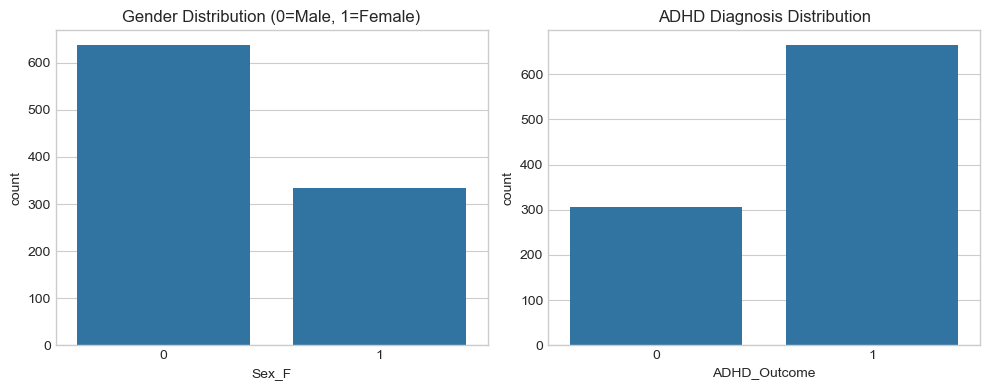

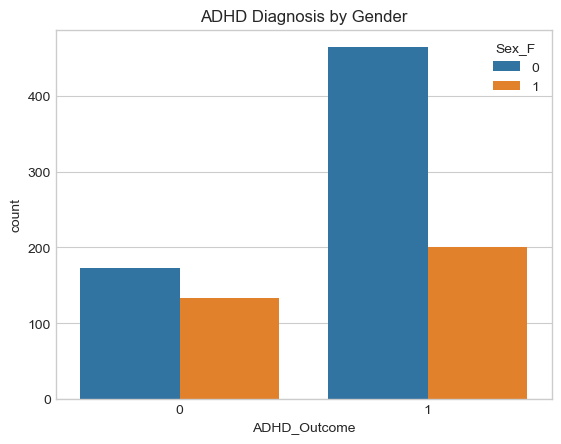

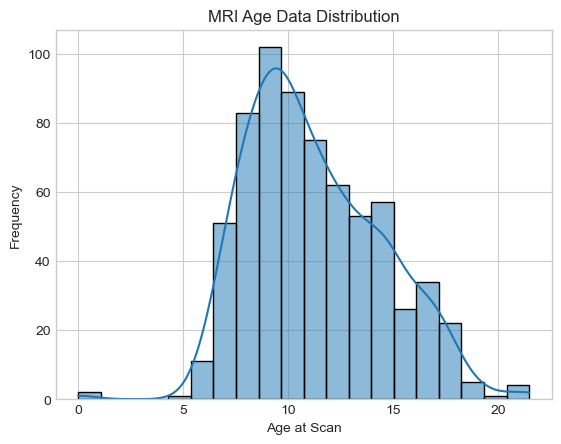

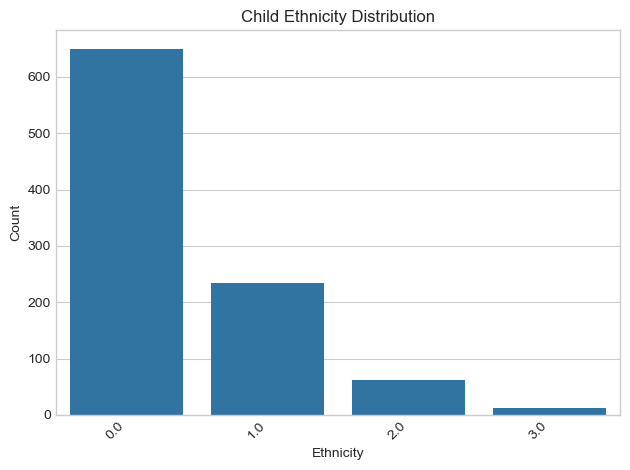

In [58]:
def explore_data(train_data, test_data=None):
    # Check for missing values in the data
    missing_values = train_data.isnull().sum()
    print("Missing Values:\n", missing_values[missing_values > 0])
    
    # Plot Sex and ADHD distributions
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x='Sex_F', data=train_data)
    plt.title("Gender Distribution (0=Male, 1=Female)")
    plt.subplot(1, 2, 2)
    sns.countplot(x='ADHD_Outcome', data=train_data)
    plt.title("ADHD Diagnosis Distribution")
    plt.tight_layout()
    plt.show()


   # Here I am checking if there is any imbalance in our target variables
# There is imbalance in number of females with AHHD is quite low, which means we will have to deal with this to
# avoid bias
    
    
    # ADHD diagnosis by gender
    plt.figure()
    sns.countplot(x='ADHD_Outcome', hue='Sex_F', data=train_data)
    plt.title("ADHD Diagnosis by Gender")
    plt.show()
    
    
    plt.figure()
    sns.histplot(train_metadata['MRI_Track_Age_at_Scan'].dropna(), kde=True)
    plt.title("MRI Age Data Distribution")
    plt.xlabel("Age at Scan")
    plt.ylabel("Frequency")
    plt.show()

# Plotting Child Ethnicity Distribution
    plt.figure()
    sns.countplot(x='PreInt_Demos_Fam_Child_Ethnicity', data=train_metadata.dropna(subset=['PreInt_Demos_Fam_Child_Ethnicity']))
    plt.title("Child Ethnicity Distribution")
    plt.xlabel("Ethnicity")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# there are two column with missing values, which will be handled later
# the age data is centered around age 9-14, this information will be useful, when handling missing value

explore_data(train_metadata)

# Removing Missing Values

In [66]:
def handle_missing_values(train_data, test_data):
    # Process training data
    train_processed = train_data.copy()
    test_processed = test_data.copy()
    
    # For MRI_Track_Age_at_Scan
    if 'MRI_Track_Age_at_Scan' in train_processed.columns:
        # Checking which features I can use for imputation
        # only numerical features can be used in iterative imputer
        numerical_cols = [col for col in train_processed.columns 
                         if train_processed[col].dtype in ["int64", "float64"]
                         and col not in ["participant_id", "Sex_F", "ADHD_Outcome", "strat_col"]]
        
        # Creating an IterativeImputer
        imp = IterativeImputer(max_iter=10, random_state=42)
        
        # Fit it on training data
        imputed_values = imp.fit_transform(train_processed[numerical_cols])
        
        # Geting the index of MRI_Track_Age_at_Scan in the numerical_cols list to ensure there is no mismatch
        age_idx = numerical_cols.index('MRI_Track_Age_at_Scan')
        
        
        train_processed['MRI_Track_Age_at_Scan'] = imputed_values[:, age_idx]
        
        # Transform test data
        imputed_test = imp.transform(test_processed[numerical_cols])
        test_processed['MRI_Track_Age_at_Scan'] = imputed_test[:, age_idx]
        
        print("Used IterativeImputer for MRI_Track_Age_at_Scan")
    
    # For PreInt_Demos_Fam_Child_Ethnicity, I will fill with 3 (Unknown)
    if 'PreInt_Demos_Fam_Child_Ethnicity' in train_processed.columns:
        train_processed['PreInt_Demos_Fam_Child_Ethnicity'] = train_processed['PreInt_Demos_Fam_Child_Ethnicity'].fillna(3)
        test_processed['PreInt_Demos_Fam_Child_Ethnicity'] = test_processed['PreInt_Demos_Fam_Child_Ethnicity'].fillna(3)
    
    # Check remaining missing values
    missing_train = train_processed.isnull().sum()
    missing_test = test_processed.isnull().sum()
    
    if sum(missing_train) > 0 or sum(missing_test) > 0:
        print("Remaining missing values in train:", missing_train[missing_train > 0])
        print("Remaining missing values in test:", missing_test[missing_test > 0])
    else:
        print("No missing values remain in either train or test datasets")
    
    return train_processed, test_processed

    

train_metadata_filled, test_metadata_filled = handle_missing_values(train_metadata, test_metadata)


Used IterativeImputer for MRI_Track_Age_at_Scan
No missing values remain in either train or test datasets


# Correlation and T-test

In [23]:
def feature_selection(train_data, test_data):
    # Features for selection (exclude targets and ID)
    features = train_data.drop(columns=['participant_id', 'Sex_F', 'ADHD_Outcome', 'strat_col']).columns
    
     # I am selecting only the numerical columns from the identified features to calculate
    # the correlation matrix.
    numerical_cols = [col for col in features if train_data[col].dtype in ["int64", "float64"]]
    if len(numerical_cols) > 1:
        correlation_matrix = train_data[numerical_cols].corr()
        
        # to find highly correlated features, I have set threshold to 0.8
        high_corr_features = set()
        threshold = 0.8
        
        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                if abs(correlation_matrix.iloc[i, j]) > threshold:
                    high_corr_features.add(correlation_matrix.columns[i])
        
        print(f"Removing {len(high_corr_features)} highly correlated features:")
        print(high_corr_features)
        
        # Removing highly correlated features
        train_processed = train_data.drop(columns=list(high_corr_features))
        test_processed = test_data.drop(columns=list(high_corr_features))
    else:
        train_processed = train_data.copy()
        test_processed = test_data.copy()
        high_corr_features = set()
    
    # Perform t-tests to identify features with gender differences

    # T-Test compare distributions between genders
    # it measures the differnce between the mean of two groups
    # Features that are significantly different between males and females can introduce bias
    # I can try removing these features if there is bias in my model
    
    p_values = {}
    print("\nT-Tests for Numerical Features by Gender:")
    numerical_cols_for_test = train_processed.select_dtypes(include=["float64", "int64"]).columns
    numerical_cols_for_test = [col for col in numerical_cols_for_test 
                              if col not in ["Sex_F", "ADHD_Outcome", "participant_id", "strat_col"]]
    
    for col in numerical_cols_for_test:
        male_vals = train_processed[train_processed["Sex_F"] == 0][col].dropna()
        female_vals = train_processed[train_processed["Sex_F"] == 1][col].dropna()
        if len(male_vals) > 1 and len(female_vals) > 1:
            t_stat, p_val = ttest_ind(male_vals, female_vals, equal_var=False)
            p_values[col] = p_val
            
            if p_val < 0.05:
                print(f"{col}: Significant difference (p = {p_val:.4f})")
    
    significant_features = [col for col in numerical_cols_for_test if col in p_values and p_values[col] < 0.05]
    print("Significant features with gender differences:", significant_features)
    
    return train_processed, test_processed, high_corr_features, significant_features

train_metadata_selected, test_metadata_selected, high_corr_features, significant_features = feature_selection(
    train_metadata_filled, test_metadata_filled)

Removing 4 highly correlated features:
{'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Hyperactivity'}

T-Tests for Numerical Features by Gender:
ColorVision_CV_Score: Significant difference (p = 0.0253)
APQ_P_APQ_P_INV: Significant difference (p = 0.0062)
APQ_P_APQ_P_OPD: Significant difference (p = 0.0096)
APQ_P_APQ_P_PP: Significant difference (p = 0.0085)
SDQ_SDQ_Conduct_Problems: Significant difference (p = 0.0433)
SDQ_SDQ_Emotional_Problems: Significant difference (p = 0.0034)
SDQ_SDQ_Prosocial: Significant difference (p = 0.0005)
Barratt_Barratt_P1_Occ: Significant difference (p = 0.0337)
Significant features with gender differences: ['ColorVision_CV_Score', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Prosocial', 'Barratt_Barratt_P1_Occ']


# Standardization

In [25]:
def standardize_features(train_data, test_data):
    # I am standardizing the data to prevent feature dominance
    num_cols = [col for col in train_data.columns 
               if train_data[col].dtype in ["int64", "float64"] 
               and col not in ["participant_id", "Sex_F", "ADHD_Outcome", "strat_col"]]
    
    
    scaler = StandardScaler()
    train_processed = train_data.copy()
    test_processed = test_data.copy()
    
    
    train_processed[num_cols] = scaler.fit_transform(train_data[num_cols])
    test_processed[num_cols] = scaler.transform(test_data[num_cols])
    
    return train_processed, test_processed, scaler

train_metadata_std, test_metadata_std, _ = standardize_features(
    train_metadata_selected, test_metadata_selected)

# Visualize FMRI Data


Exploring connectome data...
Connectome data shape: (970, 19900)
Mean: 0.004488, Std: 0.045814
Min: -0.376804, Max: 0.739065


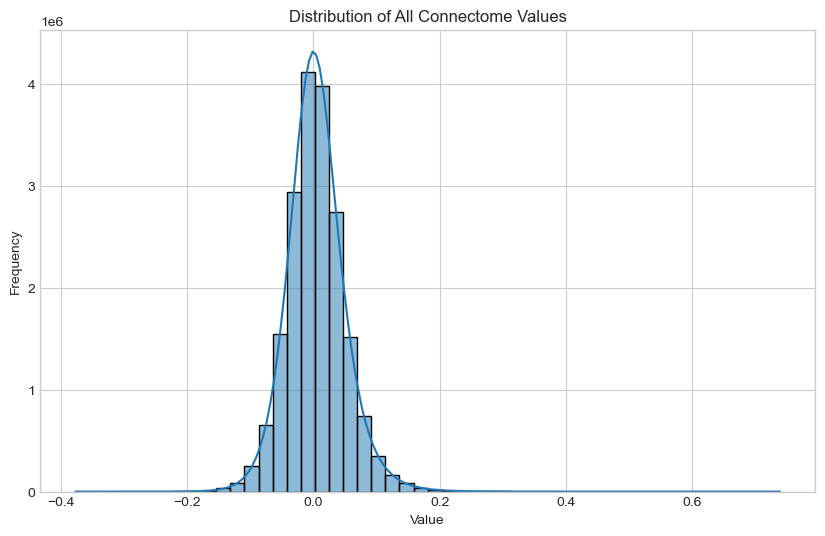

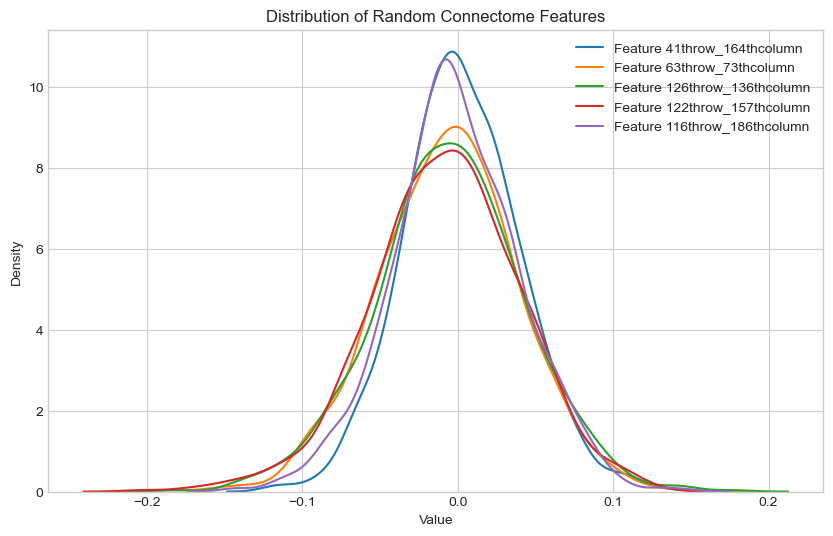

C:\Users\manas\AppData\Local\Temp\ipykernel_195292\1121155619.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


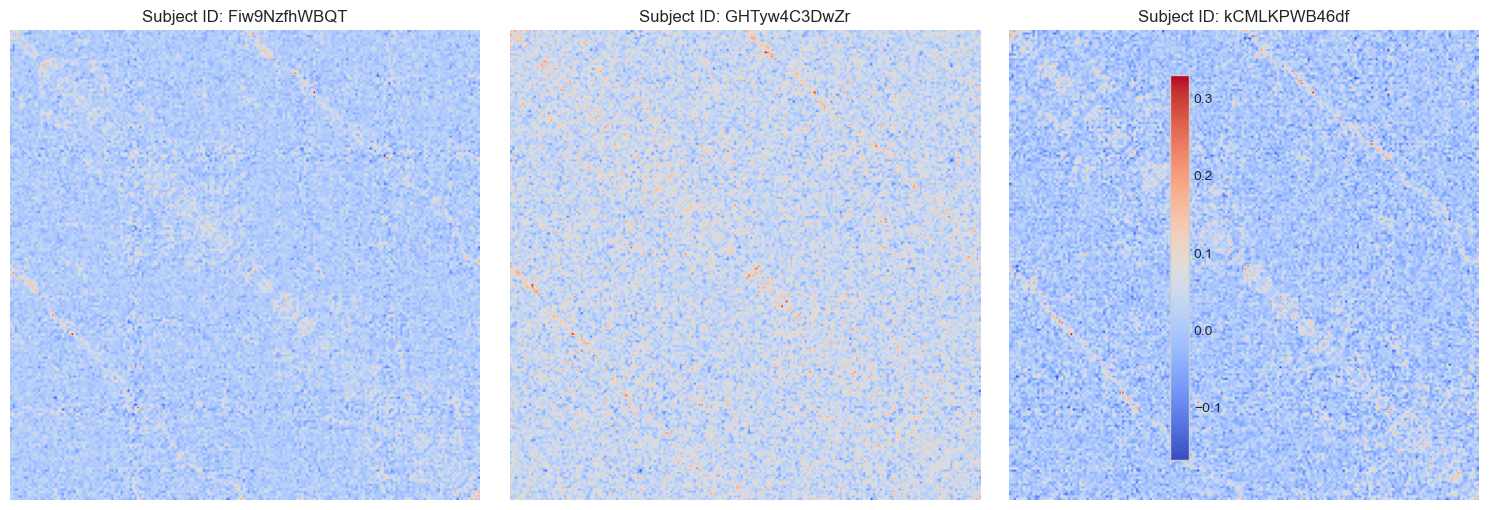

Connectome visualization complete


In [76]:
def explore_connectome_data(connectome_data, num_samples=3):
   
    print(f"Connectome data shape: {connectome_data.shape}")
    
    # Basic statistics of the connectome data, to see if it requires nomalization or not
    connectome_mean = connectome_data.values.mean()
    connectome_std = connectome_data.values.std()
    print(f"Mean: {connectome_mean:.6f}, Std: {connectome_std:.6f}")
    print(f"Min: {connectome_data.values.min():.6f}, Max: {connectome_data.values.max():.6f}")
    
    # Plot distribution of all connectome values, usd for same reson as above
    plt.figure(figsize=(10, 6))
    # Flatten all values and plot
    all_values = connectome_data.values.flatten()
    sns.histplot(all_values, bins=50, kde=True)
    plt.title('Distribution of All Connectome Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    
    # visualizing few random columns
    plt.figure(figsize=(10, 6))
    random_columns = np.random.choice(connectome_data.columns, size=5, replace=False)
    for col in random_columns:
        sns.kdeplot(connectome_data[col], label=f'Feature {col}')
    plt.title('Distribution of Random Connectome Features')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    # Visualizing a few random connectivity matrices using np.triu
    if num_samples > len(connectome_data):
        num_samples = len(connectome_data)
    
    
    random_samples = np.random.choice(connectome_data.index, size=num_samples, replace=False)
    
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    if num_samples == 1:
        axes = [axes]  
    
    for i, sample_id in enumerate(random_samples):
        # to get connectome data for this sample
        connectome_row = connectome_data.loc[sample_id].values
        
        # Determine matrix size (approximate square matrix from flattened upper triangle)
        # For a symmetric matrix, if we have n*(n-1)/2 values in upper triangle,
        # then n = (1 + sqrt(1 + 8*len(connectome_row)))/2
        n = int((1 + np.sqrt(1 + 8*len(connectome_row)))/2)
        
        
        matrix = np.zeros((n, n))
        
        # Fill upper triangular part
        idx = 0
        for r in range(n):
            for c in range(r+1, n):
                if idx < len(connectome_row):
                    val = connectome_row[idx]
                    matrix[r, c] = val
                    matrix[c, r] = val  # Mirror for symmetric matrix
                    idx += 1
        
        # Visualize matrix
        im = axes[i].imshow(matrix, cmap='coolwarm')
        axes[i].set_title(f'Subject ID: {sample_id}')
        axes[i].axis('off')  # Hide axes for cleaner visualization
    
    plt.colorbar(im, ax=axes)
    plt.tight_layout()
    plt.show()
    
    print("Connectome visualization complete")
    return connectome_mean, connectome_std

# connectome data doesn't require standardization
print("\nExploring connectome data...")
connectome_mean, connectome_std = explore_connectome_data(train_connectome, num_samples=3)

# Kernel PCA for FMRI data

In [31]:
def process_connectome(train_connectome, test_connectome, n_components=600):
    
    # Check if data needs standardization
    print(f"Connectome mean: {train_connectome.values.mean():.6f}, std: {train_connectome.values.std():.6f}")
    print("No standardization needed as data is already centered")
    
    # Apply Kernel PCA with RBF kernel (as it is better for non-linear patterns)
    gamma = 1.0 / train_connectome.shape[1]  # Default value
    
    print(f"Applying Kernel PCA with gamma={gamma:.6f} and {n_components} components")
    kpca = KernelPCA(
        n_components=n_components,
        kernel='rbf',  # Radial basis function kernel
        gamma=gamma,
        n_jobs=-1,
        random_state=42
    )
    
   
    train_kpca = kpca.fit_transform(train_connectome)
    test_kpca = kpca.transform(test_connectome)
    
    # Convert to DataFrames
    train_kpca_df = pd.DataFrame(
        train_kpca,
        index=train_connectome.index,
        columns=[f'KPCA_{i+1}' for i in range(n_components)]
    )
    
    test_kpca_df = pd.DataFrame(
        test_kpca,
        index=test_connectome.index,
        columns=[f'KPCA_{i+1}' for i in range(n_components)]
    )
    
    print(f"Kernel PCA complete - Train: {train_kpca_df.shape}, Test: {test_kpca_df.shape}")
    
    return train_kpca_df, test_kpca_df, kpca

print("\nApplying Kernel PCA to connectome data...")
train_connectome_kpca, test_connectome_kpca, kpca_model = process_connectome(
    train_connectome, test_connectome, n_components=600)


Applying Kernel PCA to connectome data...
Connectome mean: 0.004488, std: 0.045814
No standardization needed as data is already centered
Applying Kernel PCA with gamma=0.000050 and 600 components
Kernel PCA complete - Train: (970, 600), Test: (243, 600)


# Cleaned Data use for Training

In [33]:
def combine_data(train_metadata, test_metadata, train_connectome_kpca, test_connectome_kpca):
   
    # Ensure participant_id is in the index for merging
    if 'participant_id' in train_metadata.columns:
        train_meta_for_merge = train_metadata.set_index('participant_id')
        test_meta_for_merge = test_metadata.set_index('participant_id')
    else:
        train_meta_for_merge = train_metadata
        test_meta_for_merge = test_metadata
    
    # Combine metadata with connectome data
    train_combined = pd.concat([train_meta_for_merge, train_connectome_kpca], axis=1)
    test_combined = pd.concat([test_meta_for_merge, test_connectome_kpca], axis=1)
    
    # Reset index to get participant_id as a column again
    train_final = train_combined.reset_index()
    test_final = test_combined.reset_index()
    
    print(f"Final training data shape: {train_final.shape}")
    print(f"Final testing data shape: {test_final.shape}")
    
    return train_final, test_final

final_train, final_test = combine_data(
    train_metadata_std, test_metadata_std, 
    train_connectome_kpca, test_connectome_kpca)

Final training data shape: (970, 627)
Final testing data shape: (243, 627)


In [35]:
RANDOM_STATE = 42

# Prepare the data for modeling
# Separate features and targets from the final preprocessed data
X_train = final_train.drop(['participant_id', 'Sex_F', 'ADHD_Outcome', 'strat_col'], axis=1, errors='ignore')
y_train_adhd = final_train['ADHD_Outcome']
gender_train = final_train['Sex_F']

X_test = final_test.drop(['participant_id', 'Sex_F', 'ADHD_Outcome', 'strat_col'], axis=1, errors='ignore')
y_test_adhd = final_test['ADHD_Outcome']
gender_test = final_test['Sex_F']

# Keep track of feature names for interpretation
feature_names = X_train.columns.tolist()

# Saving processed Data

In [37]:
def save_data(data, filename='data.pkl'):
    
    with open(filename, 'wb') as file:
        pickle.dump(data, file)
    print(f"Data saved to {filename}")



# Save all necessary data
save_data(X_train, 'X_train_data.pkl')
save_data(y_train_adhd, 'y_train_adhd_data.pkl')
save_data(gender_train, 'gender_train_data.pkl')
save_data(X_test, 'X_test_data.pkl')
save_data(y_test_adhd, 'y_test_adhd_data.pkl')
save_data(gender_test, 'gender_test_data.pkl')
save_data(feature_names, 'feature_names.pkl')

Data saved to X_train_data.pkl
Data saved to y_train_adhd_data.pkl
Data saved to gender_train_data.pkl
Data saved to X_test_data.pkl
Data saved to y_test_adhd_data.pkl
Data saved to gender_test_data.pkl
Data saved to feature_names.pkl


# Random Forest

In [39]:
def train_rf_model(X_train, y_train, random_state=RANDOM_STATE):
    
    print("Starting Random Forest hyperparameter tuning...")
    
    # Define parameter grid for Random Forest
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': [None, 'balanced', 'balanced_subsample']
    }
    
    
    base_model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
    
    # Set up cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    # I have used RandomizedSearchCV instead of GridSearchCV for efficiency with many parameters
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=30,  # Number of parameter settings to try
        scoring='f1_weighted',  # I am Using weighted F1-score to handle class imbalance
        cv=cv,
        verbose=1,
        random_state=random_state,
        n_jobs=-1
    )
    
    
    search.fit(X_train, y_train)
    
    print(f"Best parameters: {search.best_params_}")
    print(f"Best cross-validation score: {search.best_score_:.4f}")
    
    return search.best_estimator_, search.cv_results_

print("Training ADHD detection model...")
adhd_model, cv_results = train_rf_model(X_train, y_train_adhd)

Training ADHD detection model...
Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30, 'class_weight': None}
Best cross-validation score: 0.7509


# Random Forest Model

In [41]:
def save_model(model, filename='adhd_rf_model.pkl'):
    """Save the trained model to disk using pickle"""
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {filename}")

save_model(adhd_model)

Model saved to adhd_rf_model.pkl


In [ ]:
# Predicting 

In [43]:
print("Training gender prediction model...")
y_train_sex = gender_train  
y_test_sex = gender_test  

# Training the gender prediction model
gender_model, sex_cv_results = train_rf_model(X_train, y_train_sex)


print("\nTraining gender prediction model with custom weights...")
y_train_sex = gender_train
y_test_sex = gender_test

# Calculating explicit class weights based on class distribution
class_weights = {0: 1, 1: (y_train_sex == 0).sum() / (y_train_sex == 1).sum()}
print(f"Using class weights: {class_weights}")

# Creating and training the gender model with explicit class weights
gender_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=1,
    class_weight=class_weights,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
gender_model.fit(X_train, y_train_sex)






Training Sex prediction model...
Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'class_weight': 'balanced'}
Best cross-validation score: 0.6076

Training gender prediction model with custom weights...
Using class weights: {0: 1, 1: 1.912912912912913}


RandomForestClassifier(class_weight={0: 1, 1: 1.912912912912913}, max_depth=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [45]:
with open('gender_rf_model.pkl', 'wb') as file:
    pickle.dump(gender_model, file)
print("Gender prediction model saved successfully")

Gender prediction model saved successfully


In [47]:
with open('y_test_sex.pkl', 'wb') as file:
    pickle.dump(y_test_sex, file)
print("Gender test data saved successfully")

Gender test data saved successfully


# SVM

In [49]:
def train_svm_model(X_train, y_train, param_grid=None, cv=5):
    
   
    
    # Grid search for best parameters
    print(f"Performing grid search with {cv}-fold cross-validation...")
    grid_search = GridSearchCV(
        SVC(probability=True, random_state=42),
        param_grid=param_grid,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

adhd_param_grid = {
    'C': [0.1, 1, 10, 0.001, 100, 0.0001],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', {0: 1.5, 1: 1}]
}

gender_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', {0: 1.5, 1: 1}]
}

# Training SVM Models

In [51]:
print("\n" )
print("Training SVM model for ADHD prediction...")
adhd_svm = train_svm_model(X_train, y_train_adhd, param_grid=adhd_param_grid)


print("\n" )
print("Training SVM model for Gender prediction...")
gender_svm = train_svm_model(X_train, y_train_sex, param_grid=gender_param_grid)


print("\n")
print("Saving trained models...")

with open('adhd_svm_model.pkl', 'wb') as file:
    pickle.dump(adhd_svm, file)
print("ADHD SVM model saved as 'adhd_svm_model.pkl'")

with open('gender_svm_model.pkl', 'wb') as file:
    pickle.dump(gender_svm, file)
print("Gender SVM model saved as 'gender_svm_model.pkl'")



Training SVM model for ADHD prediction...
Performing grid search with 5-fold cross-validation...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'C': 0.001, 'class_weight': {0: 1.5, 1: 1}, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.8403


Training SVM model for Gender prediction...
Performing grid search with 5-fold cross-validation...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.5021


Saving trained models...
ADHD SVM model saved as 'adhd_svm_model.pkl'
Gender SVM model saved as 'gender_svm_model.pkl'
